## importing the CSV file 

In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("data.csv")

# See the first few rows
print(df.head())


                                                 url property_id  \
0  https://immovlan.be/en/detail/apartment/for-sa...    rbu58257   
1  https://immovlan.be/en/detail/apartment/for-sa...    rbu36061   
2  https://immovlan.be/en/detail/apartment/for-sa...    vbd48093   
3  https://immovlan.be/en/detail/apartment/for-sa...    rbu58259   
4  https://immovlan.be/en/detail/apartment/for-sa...    rbu36063   

  property_type          locality_name  postal_code  build_year   state  \
0     Apartment               Brussels       1000.0      2004.0  Normal   
1     Apartment               Turnhout       2300.0      2024.0     New   
2     Apartment  Berchem-Sainte-Agathe       1082.0      1939.0  Normal   
3     Apartment               Brussels       1000.0      2013.0  Normal   
4     Apartment               Turnhout       2300.0      2024.0     New   

   living_area  furnished  number_rooms  equipped_kitchen  terrace  facades  \
0         35.0        1.0           1.0               NaN    

## Remove duplicates

In [2]:
# Count duplicates before removing
print("Duplicates before:", df.duplicated().sum())

# Remove them
df = df.drop_duplicates()

print("Duplicates after:", df.duplicated().sum())


Duplicates before: 0
Duplicates after: 0


## Remove Blank Spaces in Text Columns

In [39]:
# Go through all text (object) columns and strip spaces
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()
display(df.head())    


,url,property_id,property_type,locality_name,postal_code,build_year,state,living_area,number_rooms,terrace,facades,garden,swimming_pool,price
0,https://immovlan.be/en/detail/apartment/for-sa...,rbu58257,Apartment,Brussels,1000.0,2004.0,Normal,35.0,1.0,1.0,2.0,0,0,225000.0
1,https://immovlan.be/en/detail/apartment/for-sa...,rbu36061,Apartment,Turnhout,2300.0,2024.0,New,59.0,1.0,1.0,3.0,0,0,197000.0
2,https://immovlan.be/en/detail/apartment/for-sa...,vbd48093,Apartment,Berchem-Sainte-Agathe,1082.0,1939.0,Normal,65.0,2.0,1.0,2.0,0,0,169000.0
3,https://immovlan.be/en/detail/apartment/for-sa...,rbu58259,Apartment,Brussels,1000.0,2013.0,Normal,57.0,1.0,1.0,2.0,0,0,220000.0
4,https://immovlan.be/en/detail/apartment/for-sa...,rbu36063,Apartment,Turnhout,2300.0,2024.0,New,66.0,1.0,1.0,3.0,0,0,225000.0


## Handle Empty or Missing Values

In [46]:
import numpy as np

# Replace blank strings ("") with None
df = df.replace(r'^\s*$', np.nan, regex=True)

# Check how many missing values in each column
print(df.isna().sum())
df[df.isna().any(axis=1)]



url                 1
property_id         0
property_type     809
locality_name     190
postal_code       190
build_year       2996
state            2465
living_area      1203
number_rooms      935
terrace          1077
facades          2490
garden              0
swimming_pool       0
price             791
dtype: int64


,url,property_id,property_type,locality_name,postal_code,build_year,state,living_area,number_rooms,terrace,facades,garden,swimming_pool,price
7,https://immovlan.be/en/detail/apartment/for-sa...,rbu60048,Apartment,Brussels,1000.0,NaN,Normal,37.0,1.0,0.0,NaN,0,0,219000.0
13,https://immovlan.be/en/detail/apartment/for-sa...,vbd42948,Apartment,Ganshoren,1083.0,NaN,NaN,76.0,2.0,1.0,1.0,0,0,215000.0
18,https://immovlan.be/en/detail/apartment/for-sa...,rwc41104,Apartment,Brussels,1000.0,2015.0,Normal,76.0,1.0,NaN,NaN,0,0,225000.0
19,https://immovlan.be/en/detail/apartment/for-sa...,vbd45665,Apartment,Ganshoren,1083.0,1965.0,NaN,88.0,2.0,1.0,NaN,0,0,254000.0
26,https://immovlan.be/en/detail/apartment/for-sa...,vbd47951,Apartment,Ganshoren,1083.0,NaN,NaN,94.0,2.0,1.0,NaN,0,0,260000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7217,https://immovlan.be/en/projectdetail/24794-009...,24794-00919214_om_9933,NaN,Willebroek,2830.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
7218,https://immovlan.be/en/projectdetail/25923-723...,25923-7235431,NaN,Nevele,9850.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
7219,https://immovlan.be/en/projectdetail/vi0002198,vi0002198,NaN,Visé,4600.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
7220,https://immovlan.be/en/projectdetail/2480528-r...,2480528-rmg01404929_om_246884,NaN,Antwerp,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


## Fix Wrongly Encoded Values (e.g., text in numeric columns)

In [57]:
# Function to clean numeric columns
def to_number(s):
    return pd.to_numeric(
        s.astype(str).str.replace(r"[^\d\.\-]", "", regex=True),
        errors="coerce"
    )

# Apply to common numeric columns
numeric_cols = ["postal_code", "build_year", "living_area", "furnished","number_rooms", "facades", "garden_area","price"]

for col in numeric_cols:
    if col in df.columns:
        df[col] = to_number(df[col])
    
    # normalization for ALL boolean-like columns

    bool_cols = ["terrace","garden","swimming_pool"]

    for col in bool_cols:
        if col in df.columns:
           df[col] = normalize_bool(df[col]).fillna(0).astype(int)

    



        
print(df.info())         # check data types
print(df.isna().sum())   # missing values per column



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7222 entries, 0 to 7221
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            7221 non-null   object 
 1   property_id    7222 non-null   object 
 2   property_type  6413 non-null   object 
 3   locality_name  7032 non-null   object 
 4   postal_code    7032 non-null   float64
 5   build_year     4226 non-null   float64
 6   state          4757 non-null   object 
 7   living_area    6019 non-null   float64
 8   number_rooms   6287 non-null   float64
 9   terrace        7222 non-null   int64  
 10  facades        4732 non-null   float64
 11  garden         7222 non-null   int64  
 12  swimming_pool  7222 non-null   int64  
 13  price          6431 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 790.0+ KB
None
url                 1
property_id         0
property_type     809
locality_name     190
postal_code       190
build_year

## remove columuns (furnished,equipped_kitchen and garden area), remove the properties without prices

In [132]:
#df = df.drop(['furnished', 'equipped_kitchen', 'garden_area'], axis=1)
df = df[df["price"].notna()] # remove the properties without prices

#Categorical features: fill with "unknown".

cat_cols = ["property_type", "locality_name", "state", "region"]

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna("unknown").str.lower().str.replace(r"\s+", " ", regex=True)







## Saving cleaned data

In [37]:
df.to_csv("analysis/welde/data_cleaned.csv", index=False)
print("Cleaned file saved as data_cleaned.csv")



Cleaned file saved as data_cleaned.csv


## displaying the final data

In [40]:
display(df.head())    


,url,property_id,property_type,locality_name,postal_code,build_year,state,living_area,number_rooms,terrace,facades,garden,swimming_pool,price
0,https://immovlan.be/en/detail/apartment/for-sa...,rbu58257,Apartment,Brussels,1000.0,2004.0,Normal,35.0,1.0,1.0,2.0,0,0,225000.0
1,https://immovlan.be/en/detail/apartment/for-sa...,rbu36061,Apartment,Turnhout,2300.0,2024.0,New,59.0,1.0,1.0,3.0,0,0,197000.0
2,https://immovlan.be/en/detail/apartment/for-sa...,vbd48093,Apartment,Berchem-Sainte-Agathe,1082.0,1939.0,Normal,65.0,2.0,1.0,2.0,0,0,169000.0
3,https://immovlan.be/en/detail/apartment/for-sa...,rbu58259,Apartment,Brussels,1000.0,2013.0,Normal,57.0,1.0,1.0,2.0,0,0,220000.0
4,https://immovlan.be/en/detail/apartment/for-sa...,rbu36063,Apartment,Turnhout,2300.0,2024.0,New,66.0,1.0,1.0,3.0,0,0,225000.0


## Analysis and comparisons

Number of price outliers: 390


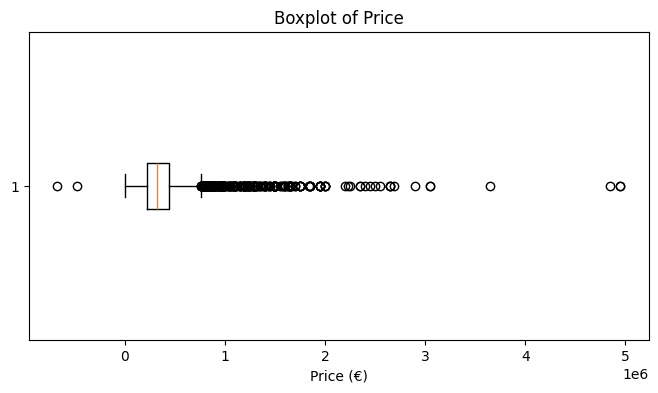

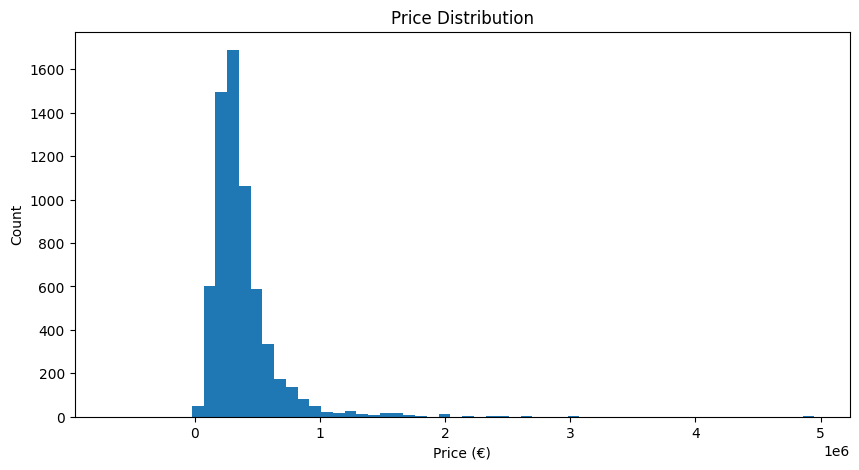

region
brussels    395000.0
flanders    339925.0
unknown          NaN
wallonia    250000.0
Name: price, dtype: float64

In [121]:

# Ensure price is numeric

df["price"] = pd.to_numeric(df["price"], errors="coerce")

Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["price"] < lower_bound) | (df["price"] > upper_bound)]

print("Number of price outliers:", len(outliers))
outliers.head()

plt.figure(figsize=(8,4))
plt.boxplot(df["price"].dropna(), vert=False)
plt.title("Boxplot of Price")
plt.xlabel("Price (€)")
plt.show()


#Identify outliers visually using a histogram

plt.figure(figsize=(10,5))
plt.hist(df["price"].dropna(), bins=60)
plt.title("Price Distribution")
plt.xlabel("Price (€)")
plt.ylabel("Count")
plt.show()

# separate for outliers



# Extract outliers into a separate DataFrame
price_outliers = df[(df["price"] < lower_bound) | (df["price"] > upper_bound)]

# Show number of outliers
#print("Number of price outliers:", len(price_outliers))

# Display the first few outliers
#price_outliers.head()



#correlation
df.corr(numeric_only=True)["price"].sort_values(ascending=False)   # correlation of Price

# add regions
def postal_to_region(code):
    if pd.isna(code):
        return "unknown"
    if 1000 <= code <= 1299:
        return "brussels"
    if (1300 <= code <= 1499) or (4000 <= code <= 7999):
        return "wallonia"
    if (1500 <= code <= 3990) or (8000 <= code <= 9992):
        return "flanders"
    return "unknown"
    
df["region"] = df["postal_code"].apply(postal_to_region)
price_outliers
df.groupby("region")["price"].median()
#df.isna().sum()



## data distributions


# global price distribution


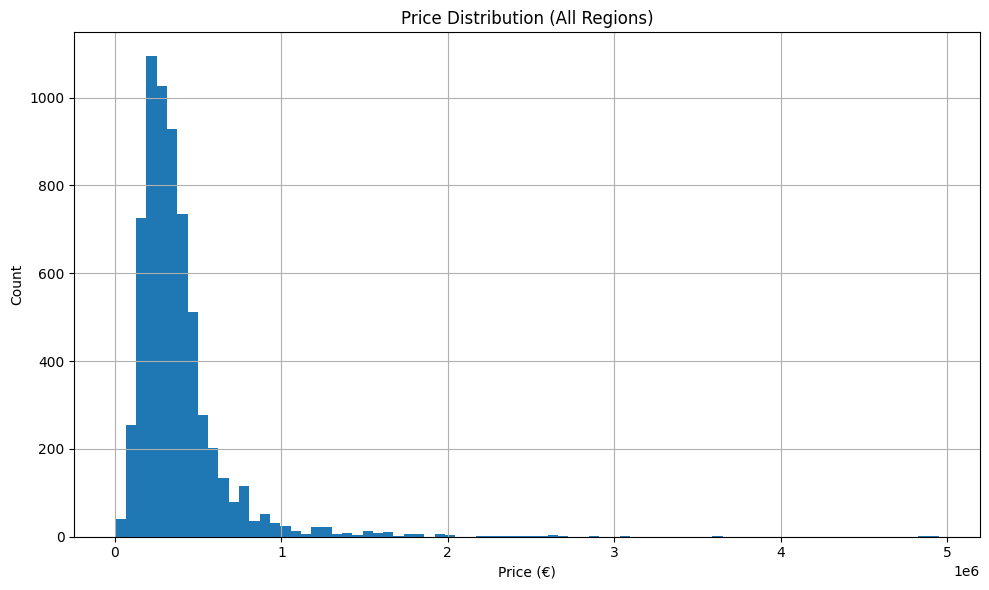

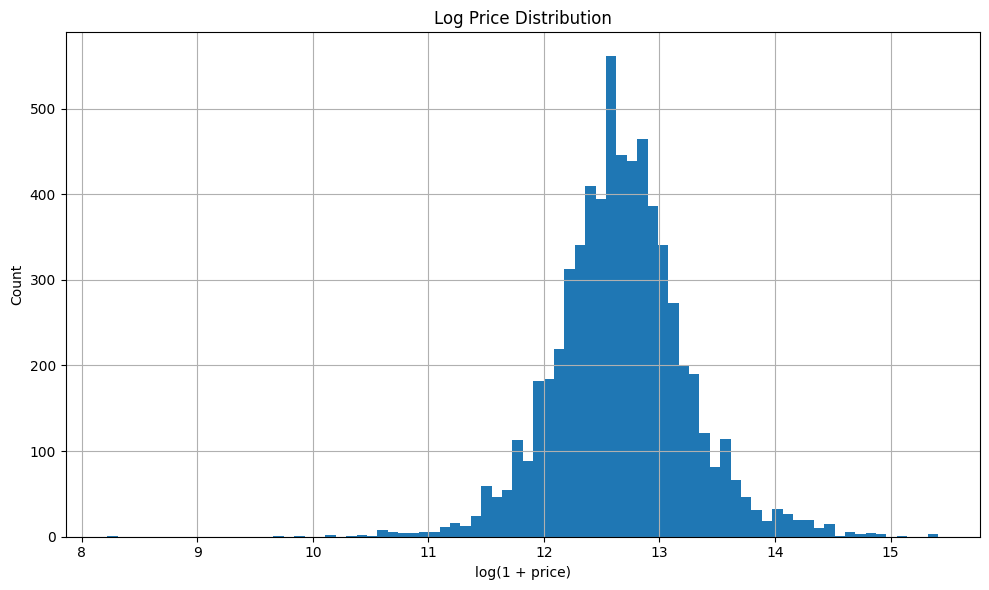

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df["price"].hist(bins=80)
plt.xlabel("Price (€)")
plt.ylabel("Count")
plt.title("Price Distribution (All Regions)")
plt.tight_layout()
plt.show()
# 
import numpy as np

plt.figure(figsize=(10,6))
np.log1p(df["price"]).hist(bins=80)
plt.xlabel("log(1 + price)")
plt.ylabel("Count")
plt.title("Log Price Distribution")
plt.tight_layout()
plt.show()


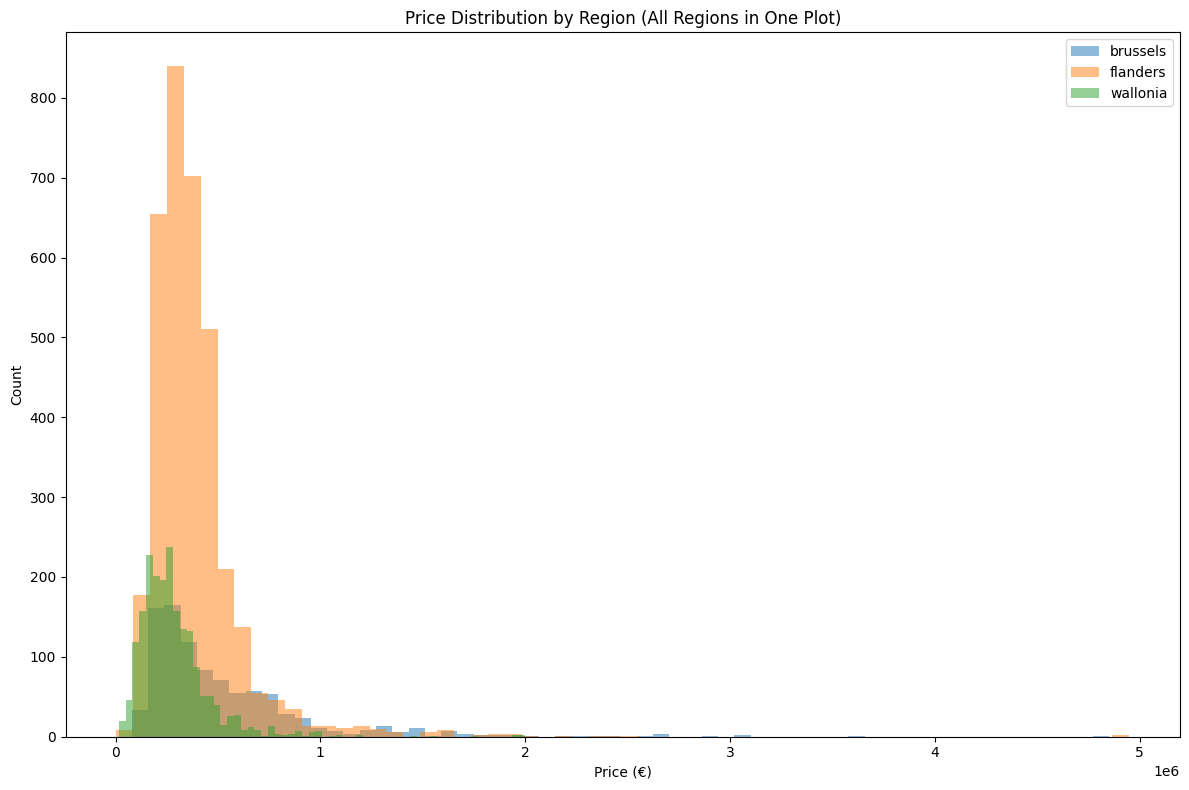

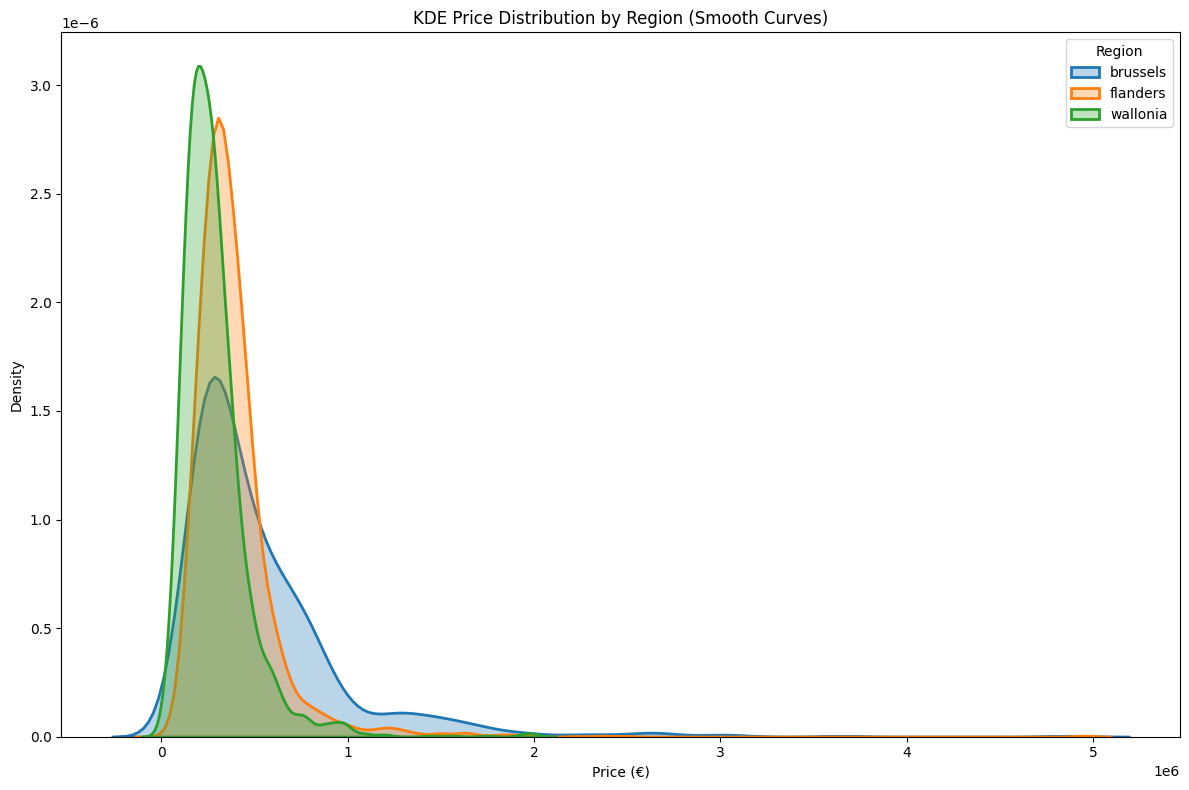

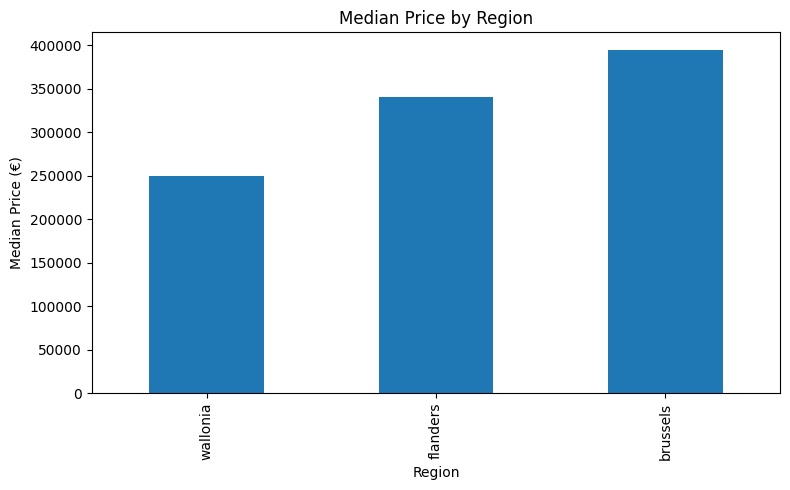

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df[df["price"].notna() & (df["price"] > 0)]


# Ensure price is numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Keep only valid prices
df_valid = df[df["price"].notna() & (df["price"] > 0)]

# Get regions with valid price data
regions = df_valid["region"].dropna().unique()

plt.figure(figsize=(12,8))

# Loop and plot all price distributions in one histogram
for region in regions:
    subset = df_valid[df_valid["region"] == region]["price"]
    if subset.dropna().empty:
        continue
    plt.hist(subset, bins=60, alpha=0.5, label=region)

plt.title("Price Distribution by Region (All Regions in One Plot)")
plt.xlabel("Price (€)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

#KDE


# Ensure price is numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Keep only valid positive prices
df_valid = df[df["price"].notna() & (df["price"] > 0)]

plt.figure(figsize=(12,8))

# Plot KDE for each region
for region in df_valid["region"].dropna().unique():
    sns.kdeplot(
        df_valid[df_valid["region"] == region]["price"],
        label=region,
        fill=True,
        alpha=0.3,
        linewidth=2
    )

plt.title("KDE Price Distribution by Region (Smooth Curves)")
plt.xlabel("Price (€)")
plt.ylabel("Density")
plt.legend(title="Region")
plt.tight_layout()
plt.show()

#by median
median_price = df.groupby("region")["price"].median().sort_values()

median_price.plot(kind="bar", figsize=(8,5))
plt.title("Median Price by Region")
plt.xlabel("Region")
plt.ylabel("Median Price (€)")
plt.tight_layout()
plt.show()


